In [1]:
import argparse
import os
import math
import numpy as np
from scipy import fftpack
from PIL import Image
from matplotlib import pyplot as plt
from skimage import img_as_ubyte
import cv2
from utility import *
from huffmantree import HuffmanTree
# from scipy.misc import imread,imsave
import imageio


把图像的长和高转换成8的倍数，并把RGB转换成YCbCr颜色模型

原动物照片的大小：
 (682, 1024, 3)
原动物卡通图片的大小：
 (715, 1000, 3)


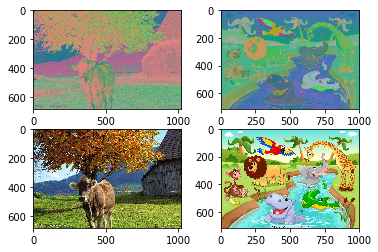

/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [16.0, 235.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [16.0, 240.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [2]:
img1 = imageio.imread('../动物照片.jpg')
img2 = imageio.imread('../动物卡通图片.jpg')

print("原动物照片的大小：\n",img1.shape)
print("原动物卡通图片的大小：\n",img2.shape)
# 块的大小
B=8 
# 图片的大小
height1,width1=(np.array(img1.shape[:2])/B * B).astype(np.int32)
img1=img1[:height1,:width1]
height2,width2=(np.array(img2.shape[:2])/B * B).astype(np.int32)
img2=img2[:height2,:width2]

mat = np.array(
    [[ 65.481, 128.553, 24.966 ],
     [-37.797, -74.203, 112.0  ],
     [  112.0, -93.786, -18.214]])
offset = np.array([16, 128, 128])
# mat = np.array(
#     [[ 0.299, 0.587, 0.144 ],
#      [-0.168736, -0.331264, 0.5  ],
#      [  0.5, -0.418688, -0.081312]])
# offset = np.array([0, 128, 128])

mat_inv = np.linalg.inv(mat)

# RGB转YCBCr
ycbcr1 = np.zeros(img1.shape)
for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
        ycbcr1[x, y, :] = np.round(np.dot(mat, img1[x, y, :] * 1.0 / 255) + offset)
    
ycbcr2 = np.zeros(img2.shape)
for x in range(img2.shape[0]):
    for y in range(img2.shape[1]):
        ycbcr2[x, y, :] = np.round(np.dot(mat, img2[x, y, :] * 1.0 / 255) + offset)

# YCbCr转RGB
rgb_img1 = np.zeros(ycbcr1.shape, dtype=np.uint8)
for x in range(ycbcr1.shape[0]):
    for y in range(ycbcr1.shape[1]):
        [r, g, b] = ycbcr1[x,y,:]
        rgb_img1[x, y, :] = np.maximum(0, np.minimum(255, np.round(np.dot(mat_inv, ycbcr1[x, y, :] - offset) * 255.0)))

rgb_img2 = np.zeros(ycbcr2.shape, dtype=np.uint8)
for x in range(ycbcr2.shape[0]):
    for y in range(ycbcr2.shape[1]):
        [r, g, b] = ycbcr2[x,y,:]
        rgb_img2[x, y, :] = np.maximum(0, np.minimum(255, np.round(np.dot(mat_inv, ycbcr2[x, y, :] - offset) * 255.0)))

# ycbcr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2YCR_CB)
# ycbcr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2YCR_CB)

# 显示YCBCR图片和RGB图片
plt.subplot(2,2,1)
plt.imshow(ycbcr1)
plt.subplot(2,2,2)
plt.imshow(ycbcr2)
plt.subplot(2,2,3)
plt.imshow(rgb_img1)
plt.subplot(2,2,4)
plt.imshow(rgb_img2)
plt.show()
imageio.imsave('../ycbcr1.jpg',ycbcr1)
imageio.imsave('../ycbcr2.jpg',ycbcr2)

进行4:2:0的二次采样
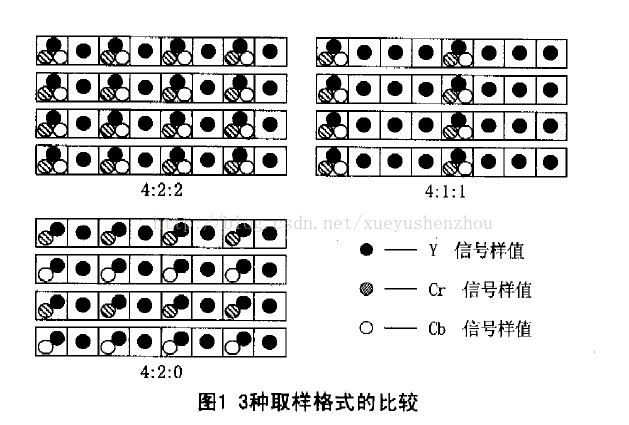

In [3]:
# 每两个像素垂直采样一次
vertical_subsample=2
# 每两个像素水平采样一次
horizontal_subsample=2

# 2*2平滑滤波（取区域内的平均值）
crf1=cv2.boxFilter(ycbcr1[:,:,1],ddepth=-1,ksize=(2,2))
cbf1=cv2.boxFilter(ycbcr1[:,:,2],ddepth=-1,ksize=(2,2))
crf2=cv2.boxFilter(ycbcr2[:,:,1],ddepth=-1,ksize=(2,2))
cbf2=cv2.boxFilter(ycbcr2[:,:,2],ddepth=-1,ksize=(2,2))
# 每隔一行和一列采样，即2*2区域内采样一次
crsub1=crf1[::vertical_subsample,::horizontal_subsample]
cbsub1=cbf1[::vertical_subsample,::horizontal_subsample]
crsub2=crf2[::vertical_subsample,::horizontal_subsample]
cbsub2=cbf2[::vertical_subsample,::horizontal_subsample]
# 将三个通道下采样后的像素值存入列表
sub_img1=[ycbcr1[:,:,0],crsub1,cbsub1]
sub_img2=[ycbcr2[:,:,0],crsub2,cbsub2]

# 输出大小检验
print("图片1：\nY值采样点数量",ycbcr1[:,:,0].size)
print("Cr值采样点数量",crsub1.size)
print("Cb值采样点数量",cbsub1.size)
# print("\n")
print("图片2：\nY值采样点数量",ycbcr2[:,:,0].size)
print("Cr值采样点数量",crsub2.size)
print("Cb值采样点数量",cbsub2.size)
# print(imSub)

图片1：
Y值采样点数量 698368
Cr值采样点数量 174592
Cb值采样点数量 174592
图片2：
Y值采样点数量 715000
Cr值采样点数量 179000
Cb值采样点数量 179000


对8x8的图像块进行二维DCT变换和量化

In [4]:
# 亮度和色度量化表
QY=np.array([[16,11,10,16,24,40,51,61],
             [12,12,14,19,26,48,60,55],
             [14,13,16,24,40,57,69,56],
             [14,17,22,29,51,87,80,62],
             [18,22,37,56,68,109,103,77],
             [24,35,55,64,81,104,113,92],
             [49,64,78,87,103,121,120,101],
             [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
             [18,21,26,66,99,99,99,99],
             [24,26,56,99,99,99,99,99],
             [47,66,99,99,99,99,99,99],
             [99,99,99,99,99,99,99,99],
             [99,99,99,99,99,99,99,99],
             [99,99,99,99,99,99,99,99],
             [99,99,99,99,99,99,99,99]])

In [5]:
# 所有dct变换后的块
dct_blocks1=[]
dct_blocks2=[]
# 所有量化后的块
quan_blocks1=[]
quan_blocks2=[]
# YCrCb颜色通道
ch=['Y','Cr','Cb']
# 量化表
Q=[QY,QC,QC]
# 所有z扫描后的向量
Zs1 = []
Zs2 = []
# 遍历每个颜色通道
for index,channel in enumerate(sub_img1):
        # 行数
        rows=channel.shape[0]
        # 列数
        cols=channel.shape[1]
        # dct变换后的块
        dct_block = np.zeros((rows,cols), np.float32)
        # 量化后的块
        quan_block = np.zeros((rows,cols), np.float32)
        # 块的行数
        block_rows=int(rows/B)
        # 块的列数
        block_cols=int(cols/B)
        
        # z扫描后的向量
        z = []
        
        block = np.zeros((rows,cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block=block-128
        # for debug
#         print(block_rows)
#         print(block_cols)
        # 处理每个块
        for row in range(block_rows):
                for col in range(block_cols):
                        # 当前块
                        currentblock = cv2.dct(block[row*B:(row+1)*B,col*B:(col+1)*B])
                        # 存储二维dct变换后的块
                        dct_block[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
                        # 存储量化后的块
                        quan_block[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[index])
                        # z扫描
                        z.append(block_to_zigzag(quan_block[row*B:(row+1)*B,col*B:(col+1)*B]).astype(np.int32))


        dct_blocks1.append(dct_block)
        quan_blocks1.append(quan_block)
        Zs1.append(z)
        
# print(len(dct_blocks1[0]))
# print(len(dct_blocks1[1]))
# print(len(dct_blocks1[2]))
print("origin block 1:\n",sub_img1[0][0:8,0:8])
print("DCT block 1:\n",dct_blocks1[0][0:8,0:8])
print("QUAN block 1:\n",quan_blocks1[0][0:8,0:8])
print("Z array:\n",Zs1[0][0])

# print(len(quan_blocks1))
# print(dct_blocks)
# print(quan_blocks)

dcs1 = dcpm(Zs1)
dcs1_values = dc(Zs1)
acs1_symbol1 = rlc(Zs1)
acs1 = ac(Zs1)
acs1_bin = rlc_values(Zs1)
# print(len(dcs1[0]))
print("DC size block 1:",dcs1[0][0])
print("DC value block 1:",dcs1_values[0][0])
# print(len(acs1_symbol1[0][0]))
print("AC values block 1:",acs1[0][0])
print("AC sizes block 1:",acs1_symbol1[0][0])
print("AC bin_str block 1:",acs1_bin[0][0])
# print(len(acs1_symbol1[0][0]))
# print(len(acs1_bin[0][0]))

H_DC_Y = HuffmanTree(dcs1[0])
H_DC_C = HuffmanTree(dcs1[1]+dcs1[2])
H_AC_Y = HuffmanTree(flatten(acs1_symbol1[0]))
H_AC_C = HuffmanTree(flatten(acs1_symbol1[1])+flatten(acs1_symbol1[2]))

tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
            'ac_y': H_AC_Y.value_to_bitstring_table(),
            'dc_c': H_DC_C.value_to_bitstring_table(),
            'ac_c': H_AC_C.value_to_bitstring_table()}

write_to_file('encode1.b', dcs1, dcs1_values,acs1_symbol1, acs1_bin,tables)

for index,channel in enumerate(sub_img2):
        # 行数
        rows=channel.shape[0]
        # 列数
        cols=channel.shape[1]
        # dct变换后的块
        dct_block = np.zeros((rows,cols), np.float32)
        # 量化后的块
        quan_block = np.zeros((rows,cols), np.float32)
        # 块的行数
        block_rows=int(rows/B)
        # 块的列数
        block_cols=int(cols/B)
        # z扫描后的向量
        z = []
        

        block = np.zeros((rows,cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block=block-128
        
        pass
        # for debug
        # print(block_rows)
        # print(block_cols)
        # print(block[0:8,0:8])
        # print(cv2.dct(block[0:8,0:8]))

        # 处理每个块        
        for row in range(block_rows):
                for col in range(block_cols):
                        # 当前块
                        currentblock = cv2.dct(block[row*B:(row+1)*B,col*B:(col+1)*B])
                        # 存储二维dct变换后的块
                        dct_block[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
                        # 存储量化后的块
                        quan_block[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[index]) 
                        # z扫描
                        z.append(block_to_zigzag(quan_block[row*B:(row+1)*B,col*B:(col+1)*B]).astype(np.int32))

        dct_blocks2.append(dct_block)
        quan_blocks2.append(quan_block)
        Zs2.append(z)
       
        
# print(len(dct_blocks1[0]))
# print(len(dct_blocks1[1]))
# print(len(dct_blocks1[2]))
print("origin block 1:\n",sub_img2[0][0:8,0:8])
print("DCT block 1:\n",dct_blocks2[0][0:8,0:8])
print("QUAN block 1:\n",quan_blocks2[0][0:8,0:8])
print("Z array:\n",Zs2[0][0])

# print(len(quan_blocks1))
# print(dct_blocks)
# print(quan_blocks)

dcs2 = dcpm(Zs2)
dcs2_values = dc(Zs2)
acs2_symbol1 = rlc(Zs2)
acs2 = ac(Zs2)
acs2_bin = rlc_values(Zs2)
# print(len(dcs1[0]))
print("DC size block 1:",dcs2[0][0])
print("DC value block 1:",dcs2_values[0][0])
# print(len(acs1_symbol1[0][0]))
print("AC values block 1:",acs2[0][0])
print("AC sizes block 1:",acs2_symbol1[0][0])
print("AC bin_str block 1:",acs2_bin[0][0])
# print(len(acs1_symbol1[0][0]))
# print(len(acs1_bin[0][0]))

H_DC_Y = HuffmanTree(dcs2[0])
H_DC_C = HuffmanTree(dcs2[1]+dcs2[2])
H_AC_Y = HuffmanTree(flatten(acs2_symbol1[0]))
H_AC_C = HuffmanTree(flatten(acs2_symbol1[1])+flatten(acs2_symbol1[2]))

tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
            'ac_y': H_AC_Y.value_to_bitstring_table(),
            'dc_c': H_DC_C.value_to_bitstring_table(),
            'ac_c': H_AC_C.value_to_bitstring_table()}

write_to_file('encode2.b', dcs2, dcs2_values,acs2_symbol1, acs2_bin,tables)
# for debug
# 根据书上的例子对DCT和量化进行测试
# block = np.array([
#                 [200, 202, 189, 188, 189, 175, 175, 175],
#                 [200, 203, 198, 188, 189, 182, 178, 175],
#                 [203, 200, 200, 195, 200, 187, 185, 175],
#                 [200, 200, 200, 200, 197, 187, 187, 187],
#                 [200, 205, 200, 200, 195, 188, 187, 175],
#                 [200, 200, 200, 200, 200, 190, 187, 175],
#                 [205, 200, 199, 200, 191, 187, 187, 175],
#                 [210, 200, 200, 200, 188, 185, 187, 186]
#             ])

# block = block - 128
# # DCT
# dct_block = fftpack.dct(fftpack.dct(block.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
# # 量化
# dct_q = (dct_block / QY).round().astype(np.int32)
# # 反量化
# i_q = dct_q * QY
# # 逆DCT
# i_block = fftpack.idct(fftpack.idct(i_q.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
# i_block = i_block + 128
# # 误差
# err = block-i_block+128

# print("原始块:\n",block+128)
# print("DCT变换系数:\n",dct_block)
# print("量化后:\n",dct_q)
# print("逆量化后:\n",i_q)
# print("重构后的:\n",i_block)
# print("误差:\n",err)

origin block 1:
 [[ 213.  174.  125.  132.  137.  100.  144.   99.]
 [ 206.  224.  108.   44.   47.   30.   19.   74.]
 [ 201.  195.  189.  176.   82.   18.   53.   29.]
 [ 191.  183.  165.  168.  191.   49.  112.   66.]
 [ 134.   53.   51.   68.  178.  159.  208.  142.]
 [ 109.   54.   58.   25.  110.  207.  162.  175.]
 [ 119.   18.   43.   42.   18.  131.  203.  201.]
 [ 193.  129.   40.   44.   59.   22.   91.  101.]]
DCT block 1:
 [[-112.625        90.57981873  155.20181274   70.25214386   32.125
    24.54866409  -36.55039215   43.3731842 ]
 [  82.54890442  247.46185303  -71.96418762  -54.25366592   -1.35391319
   -33.33273697  -40.72128296   -1.20829308]
 [ -72.82316589   51.08989334  110.66429138  -14.01447201   -0.54600382
    -1.03978515   -0.47989395  -38.34343719]
 [  45.78198624 -250.1946106    15.51844978   96.55448151  -33.46120071
    -1.13736629   52.51040268    1.79191852]
 [  68.875        16.18461609  -50.46648407   38.17147064   45.625
     2.98483419  -66.63457489 

588892

重构：
1. 逆量化
2. 逆DCT
3. 插值上采样
4. 转换成RGB

(682, 1024, 3)
(715, 1000, 3)
(682, 1024)
(682, 1024)
(682, 1024)
(682, 1024, 3)
(715, 1000)
(715, 1000)
(715, 1000)
(715, 1000, 3)


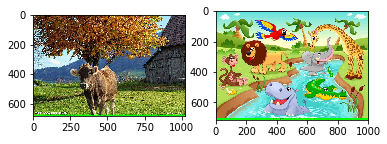

In [6]:
reCons1=np.zeros((height1,width1,3), np.uint8)
reCons2=np.zeros((height2,width2,3), np.uint8)
print(reCons1.shape)
print(reCons2.shape)

for index,channel in enumerate(quan_blocks1):
        rows=channel.shape[0]
        cols=channel.shape[1]
        block_rows=int(rows/B)
        block_cols=int(cols/B)

        block = np.zeros((rows,cols), np.uint8)
#         print(block.shape)
        for row in range(block_rows):
                for col in range(block_cols):
                        # 逆量化
                        dequantblock=channel[row*B:(row+1)*B,col*B:(col+1)*B]*Q[index]
                        # 逆DCT                        
                        currentblock = np.round(cv2.idct(dequantblock))+128
                        # 设定阈值                        
                        currentblock[currentblock>255]=255
                        currentblock[currentblock<0]=0
            
                        block[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
        #         
        back1=cv2.resize(block,(width1,height1))
        print(back1.shape)
        reCons1[:,:,index]=np.round(back1)
    
print(reCons1.shape)
# print(reCons1)

for index,channel in enumerate(quan_blocks2):
        rows=channel.shape[0]
        cols=channel.shape[1]
        block_rows=int(rows/B)
        block_cols=int(cols/B)

        block = np.zeros((rows,cols), np.uint8)
#         print(block.shape)
        for row in range(block_rows):
                for col in range(block_cols):
                        # 逆量化
                        dequantblock=channel[row*B:(row+1)*B,col*B:(col+1)*B]*Q[index]
                        # 逆DCT                        
                        currentblock = np.round(cv2.idct(dequantblock))+128
                        # 设定阈值                        
                        currentblock[currentblock>255]=255
                        currentblock[currentblock<0]=0
            
                        block[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
        #         
        back1=cv2.resize(block,(width2,height2))
        print(back1.shape)
        reCons2[:,:,index]=np.round(back1)
    
print(reCons2.shape)
# print(reCons2)

# rgb1 = cv2.cvtColor(reCons1, cv2.COLOR_YCR_CB2RGB)
# rgb2 = cv2.cvtColor(reCons2, cv2.COLOR_YCR_CB2RGB)

# YCbCr转RGB
rgb1 = np.zeros(reCons1.shape, dtype=np.uint8)
for x in range(reCons1.shape[0]):
    for y in range(reCons1.shape[1]):
        [r, g, b] = reCons1[x,y,:]
        rgb1[x, y, :] = np.maximum(0, np.minimum(255, np.round(np.dot(mat_inv, reCons1[x, y, :] - offset) * 255.0)))

rgb2 = np.zeros(reCons2.shape, dtype=np.uint8)
for x in range(reCons2.shape[0]):
    for y in range(reCons2.shape[1]):
        [r, g, b] = reCons2[x,y,:]
        rgb2[x, y, :] = np.maximum(0, np.minimum(255, np.round(np.dot(mat_inv, reCons2[x, y, :] - offset) * 255.0)))

# 显示结果
# res_img1 = Image.fromarray(reCons1,'YCbCr')
# res_img1 = res_img1.convert('RGB')
# res_img1.save('jpeg_com1.jpg')
# res_img2 = Image.fromarray(reCons2,'YCbCr')
# res_img2 = res_img2.convert('RGB')
# res_img2.save('jpeg_com2.jpg')
# Reconstructed_img1 = imageio.imread('jpeg_com1.jpg')
# Reconstructed_img2 = imageio.imread('jpeg_com2.jpg')
plt.subplot(1,2,1)
plt.imshow(rgb1)
plt.subplot(1,2,2)
plt.imshow(rgb2)
plt.show()
# imageio.imwrite('Reconstructed_img1.jpg',rgb1)
# imageio.imwrite('Reconstructed_img2.jpg',rgb2)

In [9]:
# 失真度计算

# 适用于灰度图像
# 均方差
# def MSE(reCons, origin):
#     return ((reCons - origin) ** 2).mean()
# 信噪比
# def SNR(reCons,origin):
#     return 10*math.log((origin**2).mean()/MSE(reCons, origin),10)

# 适用于RGB图像，注意shape相同
def MSE(reCons,origin):
    res = 0
    for i in range(reCons.shape[0]):
        for j in range(reCons.shape[1]):
                res += sum((reCons[i,j] - origin[i,j]) ** 2)
    res = res / (reCons.shape[0]*reCons.shape[1])
    return res 

def SNR(reCons,origin):
    res = 0;
    for i in range(origin.shape[0]):
        for j in range(origin.shape[1]):
                res += sum(origin[i,j]** 2)
    res = res / (origin.shape[0]*origin.shape[1])
    return 10*math.log(res**2/MSE(reCons, origin)**2,10)

print("JPEG\n")
print("动物图片的均方差：",MSE(rgb1,img1))
print("动物卡通图片的均方差：",MSE(rgb2,img2))
print("动物图片的信噪比：",SNR(rgb1,img1))
print("动物卡通图片的信噪比：",SNR(rgb2,img2))

gif1 = imageio.imread('../动物gif.gif')
gif2 = imageio.imread('../卡通gif.gif')
gif1 = gif1[:,:,0:3]
gif2 = gif2[:,:,0:3]
print("GIF\n")
print("动物图片的均方差：",MSE(gif1,img1))
print("动物卡通图片的均方差：",MSE(gif2,img2))
print("动物图片的信噪比：",SNR(gif1,img1))
print("动物卡通图片的信噪比：",SNR(gif2,img2))

JPEG

动物图片的均方差： 141.428259886
动物卡通图片的均方差： 111.04381958
动物图片的信噪比： 6.844158124101839
动物卡通图片的信噪比： 8.993319475662155
GIF

动物图片的均方差： 131.650367714
动物卡通图片的均方差： 98.9218447552
动物图片的信噪比： 7.466440552682235
动物卡通图片的信噪比： 9.997363176949868
